# $$Sistema~de~Recomendação:Filtragem~Colaborativa$$

## $$Conceito:$$


**Filtragem Colaborativa explora a ideia de que existe relação entre os produtos e os interesses das pessoas. Muitos sistemas de recomendação usam o Collaborative Filtering para entender essas relações e dar uma precisa recomendação de um produto que o usuário pode gostar**


**Através da similaridade(distancia) dos dados(usuário ou item), a filtragem colaborativa consegue mostrar computacionalmente, por meio de um valor, o quanto dois objetos são semelhantes entre si**



**Há dois principais tipos de algoritmos de filtragem colaborativa:**

- **Filtragem colaborativa usuário-usuário(User Based):** O sistema encontra usuários parecidos com base na similaridade e recomenda produtos que os primeiros usuários parecidos escolheram no passado. O algoritmo é muito eficaz, mas requer tempo e recursos, pois necessita que todas as informações pareadas sejam computadas, o que leva tempo.


- **Filtragem colaborativa item-item(Item Based):** É semelhante ao algoritmo anterior, mas, ao invés de encontrar usuários parecidos, tenta encontrar produtos parecidos – a partir das escolhas dos usuários. Esse algoritmo consome muito menos recursos. O sistema não precisa analisar todos os índices de similaridade entre usuários, mas sim a similaridade entre produtos – o que representa um número menor de itens ao longo do tempo




__------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------__


__------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------__

## Objetivo: Usar filtragem Colaborativa para recomendações de livros através de Avaliações de usuarios

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import sparse
from scipy.sparse import csr_matrix

# 1° Banco de dados 

In [2]:
#Banco de dados 
dados_completo = pd.read_csv("filt-colab.csv",sep=';')

dados_completo.columns = ['Usuario','Avaliacao','Titulo']
dados_completo

,Usuario,Avaliacao,Titulo
0,276725,0,Flesh Tones: A Novel
1,2313,5,Flesh Tones: A Novel
2,6543,0,Flesh Tones: A Novel
3,8680,5,Flesh Tones: A Novel
4,10314,9,Flesh Tones: A Novel
...,...,...,...
196837,276680,0,Home Crafts (Historic Communities (Paperback))
196838,276680,0,"The Old Sturbridge Village Cookbook, 2nd : Aut..."
196839,276680,0,City of Masks : A Cree Black Novel
196840,276681,10,Chorus


**Banco de dados trás as colunas: Usuario, Avaliacão e Titulo dos livros**

## Análise Exploratória dos Dados

In [36]:
# Resumo dos dados
print("Resumo dos Dados")
print("-"*50)
print("Número Total de Livro:", len(np.unique(dados_completo.Titulo)))
print("Número Total de Usuários:", len(np.unique(dados_completo.Usuario)))
print("Número Total de Avaliações:", dados_completo.shape[0])

Resumo dos Dados
--------------------------------------------------
Número Total de Livro: 68717
Número Total de Usuários: 38511
Número Total de Avaliações: 196669


In [4]:
# Verificando a média das avaliações
dados_completo.describe()['Avaliacao']

count    196842.000000
mean          3.117907
std           3.925304
min           0.000000
25%           0.000000
50%           0.000000
75%           7.000000
max          10.000000
Name: Avaliacao, dtype: float64

**Observe que as avaliações vão de 0 à 10, com média = 3.11**

In [5]:
#Verificar Valores nulos
null_Usuario = sum(dados_completo.Usuario.isna())
null_Avaliacao = sum(dados_completo.Avaliacao.isna())
null_Titulo = sum(dados_completo.Titulo.isna())

print(f'Total de dados nulos: {null_Usuario + null_Avaliacao + null_Titulo}')

Total de dados nulos: 0


**Nenhum dado nulo esta presente no dataframe**

In [6]:
# Verificando se temos valores duplicados 
dados_completo.duplicated().sum()

173

In [7]:
#Eliminar os registros duplicados
dados_completo = dados_completo.drop_duplicates()
dados_completo.duplicated().sum()

0

**Eliminamos os dados duplicados do dataset**

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


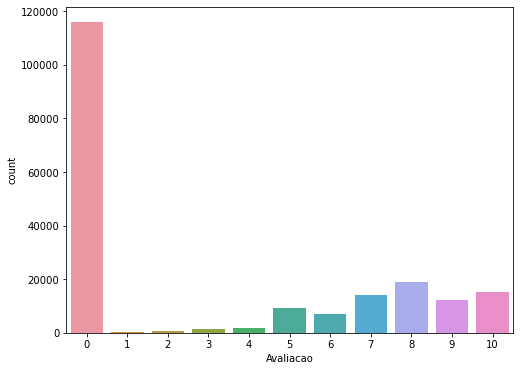

In [8]:
#Plot da coluna Avaliacao
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.countplot(dados_completo.Avaliacao);

In [9]:
#Porcentagem de avaliações com 0
zero = len(dados_completo[dados_completo.Avaliacao==0])
total = zero/len(dados_completo)
round(total*100,1)

59.0

**Veja que a distribuição está desequilibrada, com 59% das avaliações com nota 0**

**OBS: Para o sistema de recomendação dados desbalanceados não tem significância**

## Filtrar somente os usuários com mais de 10 avaliações e menos de 200 avaliações

In [10]:
# Número de avaliações por usuário
num_aval_por_user = dados_completo.groupby(by = 'Usuario')['Avaliacao'].count().sort_values(ascending = False)

#Filtrando numeros de avaliações > 200
aval200 = num_aval_por_user[num_aval_por_user>200]

#Filtrando numeros de avaliações <= 10
aval1 = num_aval_por_user[num_aval_por_user<=10]

print(f'Numero de avaliações maior que 200: {len(aval200)}')
print(f'\nNumero de avaliações menor que 10: {len(aval1)}')

Numero de avaliações maior que 200: 68

Numero de avaliações menor que 10: 35418


**Filtramos as avaliações maiores do que 200, pois o site pode ter robôs que ficam avaliando os livros, já usuários que avaliaram até 10 livros não são interessantes para o modelo, pois são usuários aleatórios que não tem engajamento com o site**

**OBS: A escolha dos valores foram arbitrarias, apenas para fins didáticos, porém com coerência na analise**

In [11]:
#Exluindo as avaliações menor que 2 e maiores que 200

#Extrair os indices dos usuarios que avaliaram mais de 200 livros 
aval_200 = dados_completo.Usuario.value_counts() < 200
aval_200 = aval_200[aval_200].index

#Extrair os indices dos usuarios que avaliaram menos de 2 livros 
aval_1 = dados_completo.Usuario.value_counts() > 10
aval_1 = aval_1[aval_1].index
aval_1

Int64Index([ 11676,  98391, 198711, 153662,  35859, 278418, 182987,  72992,
             98741, 261105,
            ...
            116210, 276602, 106131, 126726,  65208,  84897, 261412, 207450,
            277203,   2179],
           dtype='int64', length=3093)

**Índices dos usuários que tem o número de avaliações exigidas para a modelagem**

In [12]:
# Filtrar na tabela os usuarios que avaliaram menos de 200 livros

tabela_final1 = dados_completo[dados_completo['Usuario'].isin(aval_200)]

# Filtrar na tabela os usuarios que avaliaram mais de 10 livros
tabela_final1 = tabela_final1[tabela_final1['Usuario'].isin(aval_1)]

# Número de avaliações por usuário
num_aval_por_user2 = tabela_final1.groupby(by = 'Usuario')['Avaliacao'].count().sort_values(ascending = False)

maxi = num_aval_por_user2.max()
mini = num_aval_por_user2.min()

print(f'Numero maximo de avaliações feitas pelo Usuário: {maxi}')
print(f'\nNumero minimo de avaliações feitas pelo Usuário: {mini}')
print(f'\nTotal de Usuarios: {len(np.unique(tabela_final1.Usuario))}')


Numero maximo de avaliações feitas pelo Usuário: 199

Numero minimo de avaliações feitas pelo Usuário: 11

Total de Usuarios: 3025


**Agora o dataset só tem usuários com perfil equilibrado de avaliações**

In [13]:
#Verificar a quantidade de vezes que os livros foram avaliados

rating_qts = tabela_final1.groupby(by = 'Titulo')['Usuario'].count().reset_index()
rating_qts.columns = ['Titulo','Usuario']

rating_qts.sort_values(by='Usuario',ascending=False)

mini = rating_qts.Usuario.min()
maxi = rating_qts.Usuario.max()
mean = rating_qts.Usuario.mean()

print(f'Minimo de avaliações de um livro: {mini}')
print(f'\nMaximo de avaliações de um livro: {maxi}')
print(f'\nMédia de avaliações de um livro: {round(mean,1)}')

Minimo de avaliações de um livro: 1

Maximo de avaliações de um livro: 284

Média de avaliações de um livro: 2.3


**Note que a maioria dos livros tem menos de 2 avaliações, vamos selecionar os livros que tiveram mais de 20 avaliações para conseguir um modelo mais adequado**

**OBS: Novamente a escolha dos valores foram arbitrarias, apenas para fins didáticos, porém com coerência na analise**

In [14]:
#Exluindo os livros que tiveram menos de 20 avaliações 

#Extrair os indices dos usuarios que avaliaram mais de 200 livros 
livr_20 = tabela_final1.Titulo.value_counts() >20
livr_20 = livr_20[livr_20].index



In [15]:
# Filtrar na tabela os usuarios que avaliaram menos de 200 livros

tabela_final3 = tabela_final1[tabela_final1['Titulo'].isin(livr_20)]


# Número de avaliações por usuário
num_aval_por_user2 = tabela_final3.groupby(by = 'Titulo')['Usuario'].count().sort_values(ascending = False)

maxi = num_aval_por_user2.max()
mini = num_aval_por_user2.min()
mean = num_aval_por_user2.mean()

print(f'Minimo de avaliações de um livro: {mini}')
print(f'\nMaximo de avaliações de um livro: {maxi}')
print(f'\nMédia de avaliações de um livro: {round(mean,1)}')


Minimo de avaliações de um livro: 21

Maximo de avaliações de um livro: 284

Média de avaliações de um livro: 45.7


In [16]:
#Tabela completa para modelagem
tabela_final3

,Usuario,Avaliacao,Titulo
2,6543,0,Flesh Tones: A Novel
4,10314,9,Flesh Tones: A Novel
7,28523,0,Flesh Tones: A Novel
14,77480,8,Flesh Tones: A Novel
15,77940,0,Flesh Tones: A Novel
...,...,...,...
189078,231264,0,The Ghost
189147,231857,0,Dreamcatcher
190366,238526,0,A Woman of Substance
190367,238526,0,Beezus and Ramona


**Com analise previa dos dados, agora podemos ir para modelagem**

# Calcular a similaridade dos Usuários:

## Filtro Colaborativo baseado no Usuario

- Para calcular a similaridade dos usuários 1° precisamos criar uma matriz esparsa


- **A filtragem colaborativa baseada em usuários contém a distância das notas de cada usuário para as recomendações**


## Matriz Esparsas

- A Matriz esparsa cria valores 0 quando não há relação entre as linhas e as colunas, neste caso seria quando não houvesse avaliação feita pelo usuário, caso contrário o dado é o valor da avaliação


- Como o Matriz Esparsa cria valores 0, precisamos substituir as avaliações com o valor 0 para 1


- Com esses dados a Matriz Esparsa vai criar uma matriz ortogonal com os **títulos** em colunas, os **usuários** em linhas e as **avaliações** feitas pelos usuários como sendo os dados da matriz


In [17]:
## Alterar valor 0 da coluna Avaliacao

tabela_final3.loc[(tabela_final3['Avaliacao'])==0,'Avaliacao']=1

mini = tabela_final3.Avaliacao.min()

print(f'Valor minimo dado em uma avaliação: {mini}')

Valor minimo dado em uma avaliação: 1


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


**Agora com o valor mínimo da avaliação sendo 1, podemos criar a matriz esparsa**

## Criar Matriz Esparsa

- **OBS: Para criar a Matriz Esparsa precisamos que todos os dados sejam numéricos, portanto, precisaríamos transformar a coluna título que é um dado categórico em um dado numérico, e para não precisar fazer essa transformação, 1° criamos uma matriz densa com valores NaN onde não houver relações entre colunas e linhas e transformamos esses dados nulos em 0, por fim convertemos a matriz densa em uma matriz esparsa**

## Matriz Densa 

In [18]:
#Criar a matriz Densa 
Matriz_densa_user = tabela_final3.pivot_table(columns='Usuario',index='Titulo',values='Avaliacao')
Matriz_densa_user

Usuario,254,507,643,882,1211,1424,1435,1733,1903,2030,...,277427,277478,277639,277681,277711,278137,278144,278188,278563,278843
Titulo,,,,,,,,,,,,,,,,,,,,,
16 Lighthouse Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
204 Rosewood Lane,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
311 Pelican Court,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A 2nd Helping of Chicken Soup for the Soul (Chicken Soup for the Soul Series (Paper)),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A 3rd Serving of Chicken Soup for the Soul (Chicken Soup for the Soul Series (Paper)),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Widow's Walk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
Windy City Blues (V.I. Warshawski Novels (Paperback)),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Wolves of the Calla (The Dark Tower, Book 5)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Note que onde não a relação entre as linhas e colunas foram gerados dados NaN, vamos substituir os dados por 0**

In [19]:
# Substituir NaN pelo numero 0 
Matriz_densa_user.fillna(0,inplace=True)
Matriz_densa_user

Usuario,254,507,643,882,1211,1424,1435,1733,1903,2030,...,277427,277478,277639,277681,277711,278137,278144,278188,278563,278843
Titulo,,,,,,,,,,,,,,,,,,,,,
16 Lighthouse Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
204 Rosewood Lane,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
311 Pelican Court,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A 2nd Helping of Chicken Soup for the Soul (Chicken Soup for the Soul Series (Paper)),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A 3rd Serving of Chicken Soup for the Soul (Chicken Soup for the Soul Series (Paper)),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Widow's Walk,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Windy City Blues (V.I. Warshawski Novels (Paperback)),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Wolves of the Calla (The Dark Tower, Book 5)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Substituimos os valores NaN por 0 , agora podemos transformar a Matriz Densa em Esparsa**

# Transformar Matriz Densa em Matriz Esparsa

- Na tabela de matriz densa tem muitos valores zeros, e para criar o modelo esses valores zeros aumenta o poder computacional, portanto, transformamos a matriz densa em uma matriz esparsa para oculta os valores zeros

In [20]:
#Transformação
from scipy.sparse import csr_matrix
Matriz_esparsa_user = csr_matrix(Matriz_densa_user)
Matriz_esparsa_user

<363x2362 sparse matrix of type '<class 'numpy.float64'>'
	with 16562 stored elements in Compressed Sparse Row format>

In [21]:
# Calculamos a esparsidade da matriz
linhas, colunas = Matriz_esparsa_user.shape
elementos_nao_zero = Matriz_esparsa_user.count_nonzero()
print("Esparsidade da Matriz: {} % ".format(  (1 - (elementos_nao_zero / (linhas * colunas))) * 100) )

Esparsidade da Matriz: 98.06835968024484 % 


**98% da matriz contém o valor 0, que neste contexto significa que muitos usuários não avaliaram muitos Livro, o que é normal, pois se muitos usuários tivessem avaliados muitos Livro a matriz densa seria o ideal**

# Modelagem:

## Algoritimo NearestNeighbors

In [38]:
#Modelo NearestNeighbors
from sklearn.neighbors import NearestNeighbors
modelo = NearestNeighbors(algorithm='brute',n_neighbors=3,metric='euclidean')
modelo.fit(Matriz_esparsa_user)

NearestNeighbors(algorithm='brute', metric='euclidean', n_neighbors=3)

**Filtramos os 2 maiores Items mais similares para dar sugestões de livros**

In [39]:
#Sugestão de livros para quem leu Harry Potter and the Order of the Phoenix (Book 5)
distancia , sugestao =  modelo.kneighbors(Matriz_densa_user
                                          [Matriz_densa_user.index.str.contains
                                           ("Harry Potter and the Order of the Phoenix")].values.reshape(1,-1))
sugestao

array([[136,  29, 305]], dtype=int64)

In [26]:
#Convertendo os indices em nomes dos livros
k = []
for i in sugestao[0]:
    t = Matriz_densa_user.index[i]
    k.append(t)
print(f'Para quem leu o livro:\n {k[0]}')
print(f'\nAs Sugestões de livros são:\n {k[1:]}')

Para quem leu o livro:
 Harry Potter and the Order of the Phoenix (Book 5)

As Sugestões de livros são:
 ['Answered Prayers', 'The Least Likely Bride']


**Através das sugestões feitas, vamos comparar as notas de quem leu o livro 'Harry Potter and the Order of the Phoenix (Book 5') com as notas dos livros que foram indicados e verificar a coerência do algoritimo com essas indicações**

In [27]:
#Filtra os usuários que deu nota para o livro "Harry Potter and the Order of the Phoenix (Book 5)"
filt_harry =Matriz_densa_user[Matriz_densa_user.index.str.contains("Harry Potter and the Order of the Phoenix")]
filt_harry_nota = filt_harry.T>0
index_harry = filt_harry_nota[filt_harry_nota.iloc[:,0]==1].index

#Filtrar as notas do livro "Harry Potter and the Order of the Phoenix"
filt_harry1 = Matriz_densa_user.T[Matriz_densa_user.T.index.isin(index_harry)]
filt_harry1["Harry Potter and the Order of the Phoenix (Book 5)"]


Usuario
254        1.0
2033       9.0
4896       1.0
6251       9.0
6563      10.0
          ... 
267830     6.0
268030     1.0
268330     1.0
271448    10.0
274308     1.0
Name: Harry Potter and the Order of the Phoenix (Book 5), Length: 156, dtype: float64

**Todos os Usuários filtrados deram nota para o livro: 'Harry Potter and the Order of the Phoenix (Book 5)'**

**Esse é o passo mais importante para verificar como o algoritimo realizou as sugestões, pois através desses usuários que filtraremos os outros usuários que o algoritimo considerou para sugestões**

In [28]:
#Filtra os usuários que deu nota para o livro 'Answered Prayers'
filt_Prayers =Matriz_densa_user[Matriz_densa_user.index.str.contains('Answered Prayers')]
filt_Prayers_nota = filt_Prayers.T>0
index_Prayers = filt_Prayers_nota[filt_Prayers_nota.iloc[:,0]==1].index

#Filtrar as notas do livro "Harry Potter and the Order of the Phoenix"
filt_Prayers1 = Matriz_densa_user.T[Matriz_densa_user.T.index.isin(index_Prayers)]
filt_Prayers1['Answered Prayers']

Usuario
6563       1.0
25981      1.0
40889      8.0
46909      7.0
55734      1.0
62688      1.0
85426      1.0
101874     1.0
104636     1.0
114414     1.0
145451     1.0
153718     1.0
179733     1.0
179734    10.0
204522     1.0
211426     1.0
217375     1.0
228764     1.0
242646     1.0
254465     1.0
262399     1.0
266807     1.0
Name: Answered Prayers, dtype: float64

**Todos os Usuários filtrados deram nota para o livro: 'Answered Prayers'**

In [29]:
#Filtra os usuários que deu nota para o livro 'The Least Likely Bride'
filt_Bride =Matriz_densa_user[Matriz_densa_user.index.str.contains('The Least Likely Bride')]
filt_Bride_nota = filt_Bride.T>0
index_Bride = filt_Bride_nota[filt_Bride_nota.iloc[:,0]==1].index

#Filtrar as notas do livro 'The Least Likely Bride'
filt_Bride1 = Matriz_densa_user.T[Matriz_densa_user.T.index.isin(index_Bride)]
filt_Bride1['The Least Likely Bride']

Usuario
9908      1.0
11629     1.0
14422     1.0
52614     1.0
77940     1.0
89014     1.0
107021    1.0
118275    1.0
131837    1.0
140358    5.0
164027    1.0
172030    1.0
186039    1.0
189973    3.0
196077    1.0
204522    1.0
210035    1.0
228764    1.0
231857    1.0
235392    1.0
245827    1.0
257700    1.0
258185    1.0
Name: The Least Likely Bride, dtype: float64

**Todos os Usuários filtrados deram nota para os livros: 'The Least Likely Bride'**

# Conclusão 1:

**Não precisamos seguir em frente na análise com esses dados, pois conseguimos perceber que a maioria das avaliações são de notas baixas, portanto o algoritimo está considerando a distância das notas baixas para dar recomendações de livros. Se 2 pessoas leram alguns livros semelhantes e deram notas baixas, o algoritimo está indicando livros que também tiveram nota baixa para esses usuários**

# Verificar as notas dos usuários em comum com o livro 'Harry Potter and the Order of the Phoenix (Book 5)'

- Verificar através dos dados a conclusão 1

In [37]:
#Verificar o ID dos usuarios que deram notas para o Livro "Harry Potter and the Order of the Phoenix" e 
# para também para o Livro'Answered Prayers'

h = []
for i in filt_harry1.index.values:
    for g in filt_Prayers1.index.values:
        if i == g:
            h.append(i)
                
print(f'Os Usuáios que deram notas para os 2 Livros foram os IDs: {h}')                



Os Usuáios que deram notas para os 2 Livros foram os IDs: [6563, 25981, 85426, 145451, 179734, 211426]


**Todos os Usuários filtrados deram nota para os livros: 'Harry Potter and the Order of the Phoenix (Book 5)' e 'Answered Prayers'**

In [35]:
#Filtraros livros do usuario '6563'
ff = Matriz_densa_user[h]>0
ff[ff[6563]==1]

ind = ff[ff[6563]==1].index


#Filtrar notas 
ff = Matriz_densa_user[h]
ff[ff.index.isin(ind)]

Usuario,6563,25981,85426,145451,179734,211426
Titulo,,,,,,
A 4th Course of Chicken Soup for the Soul: 101 More Stories to Open the Heart and Rekindle the Spirit,1.0,0.0,0.0,0.0,0.0,0.0
A Patchwork Planet,1.0,0.0,0.0,0.0,0.0,0.0
A Second Chicken Soup for the Woman's Soul (Chicken Soup for the Soul Series),5.0,0.0,0.0,0.0,0.0,0.0
Answered Prayers,1.0,1.0,1.0,1.0,10.0,1.0
Chicken Soup for the Christian Soul (Chicken Soup for the Soul Series (Paper)),5.0,0.0,0.0,0.0,0.0,0.0
Chocolat,1.0,0.0,0.0,0.0,0.0,0.0
Flesh and Blood,1.0,0.0,0.0,0.0,0.0,0.0
GARDEN OF SHADOWS (Dollanger Saga (Paperback)),1.0,0.0,0.0,0.0,0.0,0.0
Girl in Hyacinth Blue,8.0,0.0,1.0,0.0,0.0,7.0


**Filtro das notas do usuário '6563', note que a semelhança é mínima entre as notas dos usuários, o que consegue-se perceber é que todos os usuários que deram nota para o livro 'Harry Potter and the Order of the Phoenix (Book 5)' também deram nota para o livro 'Answered Prayers'**

In [33]:
#Filtrar a notas dos usuarios que leram o livro: 'Harry Potter and the Order of the Phoenix (Book 5)'
f_user = Matriz_densa_user[h]
f_user = f_user.T
pd.DataFrame(f_user['Harry Potter and the Order of the Phoenix (Book 5)'])

,Harry Potter and the Order of the Phoenix (Book 5)
Usuario,
6563,10.0
25981,1.0
85426,1.0
145451,1.0
179734,10.0
211426,1.0


**Veja apenas as notas do livro 'Harry Potter and the Order of the Phoenix (Book 5)' dos usuários que também leram 'Answered Prayers'**

# Conclusão 2

**Podemos afirmar que os usuários que deram nota alta para o livro do 'Harry Potter', pode ter similaridade, também podemos afirmar que os usuários que deram nota baixa para o livro do 'Harry Potter' e nota alta para outros livros iguais, também podem ter similaridade, agora não podemos afirmar que apenas para quem deu nota baixa para o livro do 'Harry Potter', pode ter similaridade**

**Com a conclusão acima podemos perceber que não adianta apenas filtrar as notas altas dos usuários, pois iria excluir muitos livros que também poderia ter similaridade com outro usuário através das notas altas e baixas**